In [62]:
import os
import time
import torch
import pickle

import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)

os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [63]:
#Used to return first n items of the iterable as a list
from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
  print("=================================")
  print("GPU found")
  print("Using GPU at cuda:",torch.cuda.current_device())
  print("=================================")
  print(" ")

GPU found
Using GPU at cuda: 0
 


In [65]:
model1 = torch.load("~/NNTI-WS2021-NLP-Project/Project_files/Hindi/epoch_300.pt")

w1 = model1["w1.weight"].T
w2 = model1["w2.weight"]


cleandata = pd.read_pickle("~/NNTI-WS2021-NLP-Project/Project_files/Hindi/hindi_corpus_cleaned.pkl")
word_index = pd.read_pickle("~/NNTI-WS2021-NLP-Project/Project_files/Hindi/word_index.pkl")
index_word = pd.read_pickle("~/NNTI-WS2021-NLP-Project/Project_files/Hindi/index_word.pkl")
V = pd.read_pickle("~/NNTI-WS2021-NLP-Project/Project_files/Hindi/vocab.pkl")

In [66]:
data = pd.read_csv('https://raw.githubusercontent.com/SouravDutta91/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv',sep='\t')
text = data[['text','task_1']]
text['text'] = cleandata['text'].apply(lambda x: x.split())
text['label'] = text['task_1'].apply(lambda x: 1 if x == 'HOF' else 0)
max_len = text.text.str.len().max()

In [67]:
#Function to count the labels in a dataset
def tag_count(input):
  hcount,ncount = 0,0
  for tag in input:
    if tag == 1:
      hcount+=1
    else:
      ncount+=1
  return hcount,ncount

In [68]:
'''Word-index dictionaries are updated with '<pad>' word which is used for padding,
that is to make the sentences uniform in length'''

word_index['<pad>'] = len(V)
index_word[len(V)] = '<pad>'


In [69]:
#Function to get the word embedding from the weight
def get_word_embedding(input):
    index = word_index[input]
    return w1[index]

In [70]:
#Creates the embedding matrix by using the word embeddings and adds zeroes for all the '<pad>' words
def matrix_embeddings():
    _ , emb_size = w1.shape
    embedding_matrix = np.random.uniform(-1, 1, (len(word_index), emb_size))
    embedding_matrix[word_index['<pad>']] = np.zeros((emb_size,))

    for word,i in take(len(V),word_index.items()):
      temp = get_word_embedding(word)
      if temp is not None:
          embedding_matrix[i] = temp.cpu()
    return embedding_matrix

In [71]:
#Encodes the sentences into their respective indexes
def encode(corpus):
  sent_idx = []
  i = 0
  for sentence in corpus:
    sentence += ['<pad>'] * (max_len - len(sentence))
    idx = [word_index[word] for word in sentence]
    sent_idx.append(idx)
    i+= 1
  return np.array(sent_idx)

In [72]:
#store the encoding,labels and the embeddings
encoded_text = encode(text.text)
labels = np.array(text['label'])
embeds = torch.tensor(matrix_embeddings())

In [73]:
embeds

tensor([[-0.3367,  0.3636, -0.3046,  ...,  0.0300, -0.2679, -0.4148],
        [ 0.0883,  0.0739,  0.1094,  ..., -0.1064, -0.0681, -0.2677],
        [-0.2731,  0.1393,  0.2855,  ...,  0.0173,  0.2927,  0.2280],
        ...,
        [ 0.2724, -0.0797, -0.0919,  ..., -0.3751,  0.1591,  0.1360],
        [-0.0535,  0.1561, -0.0446,  ...,  0.0316, -0.3634, -0.2427],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [74]:
#split the data into train and test sets with train set being 0.8 and test being the remaining 0.2
xtrain, xtest, ytrain, ytest = train_test_split(encoded_text,labels,shuffle=True,test_size=0.2,random_state=15)


#Creating a dataloader for train and test sets
def get_dataloader(traindata, testdata, trainlabels, testlabels ,batchsize):
   
   traindata = torch.tensor(traindata).float()
   testdata = torch.tensor(testdata).float()
   trainlabels = torch.tensor(trainlabels)
   testlabels = torch.tensor(testlabels)
   
   train = TensorDataset(traindata,trainlabels)
   train_dataload = DataLoader(train,sampler=RandomSampler(train),batch_size=batchsize,drop_last=True)
   test = TensorDataset(testdata,testlabels)
   test_dataload = DataLoader(test,sampler=RandomSampler(test),batch_size=batchsize,drop_last=True)

   return train_dataload,test_dataload

batchsize = 50
train_dataload,test_dataload = get_dataloader(xtrain, xtest, ytrain, ytest,batchsize)

In [75]:
#Return the label count
th,tc = tag_count(ytrain)
testh,testc = tag_count(ytest)
            
print("The train dataset has {} HOF labels and {} NOT labels.".format(th,tc))
print("The test dataset has {} HOF labels and {} NOT labels.".format(testh,testc))

The train dataset has 1967 HOF labels and 1765 NOT labels.
The test dataset has 502 HOF labels and 431 NOT labels.


In [76]:
#Creating the CNN model
class hindi_cnnmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.word_embed = embeds
    self.filter_sizes = [2, 3, 4] #Size of the Kernel
    self.num_filters = [50, 50, 50] #3 convolution layers each with 50 filters
    self.num_classes=2 #Number of classes
    self.dropout=0.5 #Prevents overfitting
    self.vlen,self.es = self.word_embed.shape
    self.embedding = nn.Embedding.from_pretrained(self.word_embed) #Loading the trained word embedding matrix

    #1D convolution is used to detect the features in the sentences. Each filter returns a feature map 
    self.conv1d = nn.ModuleList([nn.Conv1d(in_channels=self.es,out_channels=self.num_filters[i],kernel_size=self.filter_sizes[i])
        for i in range(len(self.filter_sizes))])
    
    self.fc = nn.Linear(np.sum(self.num_filters), self.num_classes)
    self.dropout1 = nn.Dropout(p=self.dropout)

  def forward(self,input1):
    x_e = self.embedding(input1).float()
    x_r = x_e.permute(0,2,1)
    #ReLU and maxpool is used to reduce the feature map into a single scalar
    #Maxpool will capture the best feature from the feature map
    conv_list = [F.relu(conv(x_r)) for conv in self.conv1d]
    x_maxpool = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in conv_list]
    
    #Fully connected layer
    x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_maxpool],dim=1)
    drop = self.dropout1(x_fc)
    output = self.fc(drop)
    return output

In [77]:
#Initializing the model
model = hindi_cnnmodel()

#Sending the model to GPU
model.cuda()

print(model)

#Setting the paraters
learning_rate = 0.05
epochs = 10

#We use SGD optimizer and CrossEntropyLoss
optimizer = optim.SGD(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

hindi_cnnmodel(
  (embedding): Embedding(17788, 300)
  (conv1d): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(4,), stride=(1,))
  )
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [78]:
def train(train_dataload,test_dataload):
  accuracy = 0
  print("Training started")
  start = time.time()
  losses = []
  test_loss = []

  for epoch in range(epochs):
    totloss = 0
    model.train()
    
    #Take a batch at a time from the dataloader
    for i,batch in enumerate(train_dataload):
      #Send the input and the label to GPU  
      x_train,y_train = tuple(x.to(torch.int64).cuda() for x in batch)
      print(type(x_train))
      #Compute the loss
      model.zero_grad() #Make previous calculated gradients zero
      output = model(x_train)
      loss = criterion(output,y_train)
      totloss += loss.item() 
      loss.backward() #Compute gradients
      optimizer.step() #updates weights
    
    # Calculate the average loss over the entire training data
    train_loss = totloss/len(train_dataload)
    losses.append(train_loss)    
    
    testloss,testacc = test_acc(test_dataload)
    test_loss.append(testloss)
    
    if testacc > accuracy:
      accuracy = testacc
    
    print("At epoch {} the training loss is {}, the test loss is {} and accuracy of {}%".format(epoch,round(testloss,3),round(train_loss,3),round(accuracy,2)))
  
  #Plotting the train loss and the test loss at the end
  plt.plot(losses,label="train")
  plt.plot(test_loss,label="test")
  plt.xlabel("EPOCHS")
  plt.ylabel("LOSS")
  plt.legend()
  plt.show()
  print("Training ended")

In [79]:
def test_acc(test_dataload):
  #By putting the model into evaluation mode, the dropout layers are stopped for the time being
  model.eval()
  testacc = []
  testloss = []

  for batch in test_dataload:
    x_test,y_test = tuple(x.to(torch.int64).cuda() for x in batch)

    with torch.no_grad():
        output = model(x_test) #Computing logits
    #Calculate the test loss
    loss = criterion(output,y_test)
    testloss.append(loss.item())
    
    #Calculate the predictions and its accuracy
    preds = torch.argmax(output,dim=1).flatten()

    accu = (preds == y_test).cpu().numpy().mean() * 100
    testacc.append(accu)
    
  x = np.mean(testloss)
  y = np.mean(testacc)

  return x,y

Training started
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Ten

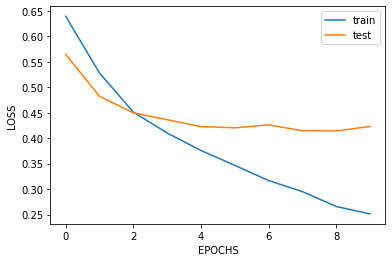

Training ended


In [80]:
train(train_dataload,test_dataload)